# Imbalance Dataset Problem
One of the most common difference between real world data and "fake data" is most of the datasets in real world are 
highly imbalanced. In this notebook, we will learn some of the techniques 

## Sampling

1. Random Undersampling
2. Random Oversampling
3. SMOTE

## Performance Metrics
1. ROCAUC

## Penalized algorithms
1. 

## Random Forest
1. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Balance Scale Dataset
Let's the load the balance scale dataset taken from UCI as source

Target variable:

The target variable has 3 classes.

R for right-heavy, i.e. when var3 * var4 > var1 * var2
L for left-heavy, i.e. when var3 * var4 < var1 * var2
B for balanced, i.e. when var3 * var4 = var1 * var2

In [3]:
##load data
bs_data = pd.read_csv("data/balance-scale.data")

We can also open the webpage to know more about this dataset

In [4]:
from IPython.display import IFrame
IFrame('http://archive.ics.uci.edu/ml/datasets/balance+scale', width=1200, height=600)

## Explore the dataset
The data is now been loaded to a pandas dataframe, let's try to understand the data a bit more before starting with undersampling

In [5]:
##Check the dataset
bs_data.head()

,B,1,1.1,1.2,1.3
0,R,1,1,1,2
1,R,1,1,1,3
2,R,1,1,1,4
3,R,1,1,1,5
4,R,1,1,2,1


Let's now rename the columns to more sensible ones. We can rename the column names as "balance", "leftWeight", 
"leftDistance", "rightWeight" and "rightDistance"

In [6]:
##Rename columns
bs_data.columns = ["label", "leftWeight", "leftDistance", "rightWeight", "rightDistance"]

As we have learned in our previous notebooks, to get more information about variables we can use df.describe()

In [7]:
bs_data.describe()

,leftWeight,leftDistance,rightWeight,rightDistance
count,624.000000,624.000000,624.000000,624.000000
mean,3.003205,3.003205,3.003205,3.003205
std,1.414210,1.414210,1.414210,1.414210
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [8]:
### Check distibution of label
target_column = 'label'
bs_data[target_column].value_counts()

R    288
L    288
B     48
Name: label, dtype: int64

## Transform into binary classification problem
For this tutorial, let's turn this into a binary classification problem. 
Label:1 -- Implies balanced scale
Label:0 -- Implies imbalanced scale

In [9]:
bs_data['label'] = [1 if b=='B' else 0 for b in bs_data.label]
bs_data[target_column].value_counts()

0    576
1     48
Name: label, dtype: int64

In [10]:
##Quick Null Value Analysis
bs_data.isnull().sum().max()

0

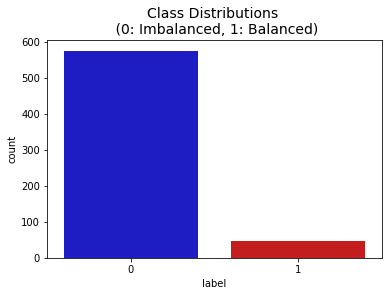

In [19]:
import seaborn as sns
colors = ["#0101DF", "#DF0101"]

sns.countplot('label', data=bs_data, palette=colors)
plt.title('Class Distributions \n (0: Imbalanced, 1: Balanced)', fontsize=14)
plt.show()

In [30]:
## Percentage of Balanced and Imbalanced data
print('Imbalance Class', round(float(bs_data['label'].value_counts()[0])/len(bs_data) * 100,2), '% of the dataset')
print('Balance Class', round(float(bs_data['label'].value_counts()[1])/len(bs_data) * 100,2), '% of the dataset')

('Imbalance Class', 92.31, '% of the dataset')
('Balance Class', 7.69, '% of the dataset')


# Train a model with imbalanced data
Let's train a simple logistic regression model with this data as input and understand the importance of treating imbalanced data differently

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [16]:
# Separate input features (X) and target variable (y)
y = bs_data.label
X = bs_data.drop('label', axis=1)
 
# Train model
clf_0 = LogisticRegression().fit(X, y)
 
# Predict on training set
y_pred = clf_0.predict(X)

Let's check the accuracy score for this model.. 

In [31]:
print(accuracy_score(y_pred, y) )

0.923076923077


How about printing the Confusion Matrix?

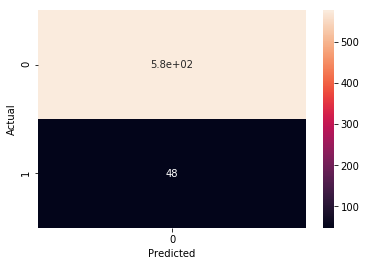

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

Let's get the classification report to get more clearer insights on the results

In [34]:
from sklearn.metrics import classification_report
target_names = ['Imbalanced', 'Balanced']
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Imbalanced       0.92      1.00      0.96       576
    Balanced       0.00      0.00      0.00        48

   micro avg       0.92      0.92      0.92       624
   macro avg       0.46      0.50      0.48       624
weighted avg       0.85      0.92      0.89       624



/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Sampling Treatment
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).
<img src="images/resampling.png">
## 1. Random Undersampling: imbalanced-learn
Let's reduce the dimensions of our dataset to have a better understanding of our data points

In [36]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

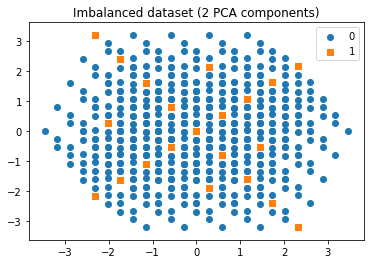

In [40]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plot_2d_space(X_reduced, y, 'Imbalanced dataset (2 PCA components)')

Now let's try undersampling randomly and visualize the results

After fitting to RandomUnderSampler object, it returns three values are returned: Undersampled values of X and Y
and discarded indices.

In [1]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

ImportError: No module named imblearn.under_sampling

In [2]:
## 2. Upsample Minority Class
Upsampling can be done in various ways, one of the ways is to randomly duplicate the minority class 

SyntaxError: invalid syntax (<ipython-input-2-a33ec09fd21d>, line 2)

In [3]:
import sys
sys.executable

'/usr/local/opt/python/bin/python2.7'